In [22]:
import catboost
import matplotlib
import numpy as np
import pandas as pd
from catboost import CatBoost
from scipy.stats import ttest_ind
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [23]:
data = pd.read_csv('data/train.csv')
print(data.shape)
data = data.join(pd.read_csv('data/y_train.csv'), how='left')
print(data.shape)
data.head(2)

(720000, 58)
(720000, 59)


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,y_train
0,"-131,97405146667",12.0,"13,0",11.747860,1.0,2.0,"22,0","-27,750277493704",9.0,NaN,...,3.0,"11,0",40.588345,16.957673,14.360604,"-53,415701398274706",NaN,NaN,-40.849368,1
1,"-48,3041715861774",9.0,"10,0",10.436009,1.0,NaN,"24,0","-25,703719919085497",8.0,0.0,...,2.0,NaN,27.113802,-61.457339,2.627029,"-39,6179932194784",24.686063,NaN,-45.108764,1


In [24]:
#приводим все поля к типу цифровому типу данных, что бы было удобнее с ними работать
for c in data.columns:
    if data[c].dtype == 'O':
        data[c] = data[c].str.replace(',', '.').astype(float)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720000 entries, 0 to 719999
Data columns (total 59 columns):
feature_1     656351 non-null float64
feature_2     647084 non-null float64
feature_3     665252 non-null float64
feature_4     662312 non-null float64
feature_5     655438 non-null float64
feature_6     637388 non-null float64
feature_7     633071 non-null float64
feature_8     637224 non-null float64
feature_9     672108 non-null float64
feature_10    635192 non-null float64
feature_11    633531 non-null float64
feature_12    657614 non-null float64
feature_13    641144 non-null float64
feature_14    658199 non-null float64
feature_15    628189 non-null float64
feature_16    657553 non-null float64
feature_17    643402 non-null float64
feature_18    646214 non-null float64
feature_19    685924 non-null float64
feature_20    663822 non-null float64
feature_21    643262 non-null float64
feature_22    651121 non-null float64
feature_23    614819 non-null float64
feature_24    6

In [26]:
data_stats = data.describe().T
data_stats

,count,mean,std,min,25%,50%,75%,max
feature_1,656351.0,11.076267,100.034568,-480.088690,-56.323033,11.137026,78.460599,483.022802
feature_2,647084.0,12.329582,0.796751,7.000000,12.000000,13.000000,13.000000,13.000000
feature_3,665252.0,11.342324,1.662567,3.000000,10.000000,11.000000,13.000000,15.000000
feature_4,662312.0,25.416516,20.630278,-72.310070,11.521055,25.435029,39.343553,128.900592
feature_5,655438.0,0.313636,0.537229,0.000000,0.000000,0.000000,1.000000,4.000000
feature_6,637388.0,2.181676,0.770063,0.000000,2.000000,2.000000,3.000000,3.000000
feature_7,633071.0,23.222787,0.867250,17.000000,23.000000,23.000000,24.000000,24.000000
feature_8,637224.0,-46.308927,19.882869,-138.181159,-59.732242,-46.295015,-32.910225,55.334255
feature_9,672108.0,7.902202,1.285814,1.000000,7.000000,8.000000,9.000000,10.000000
feature_10,635192.0,0.269337,0.443616,0.000000,0.000000,0.000000,1.000000,1.000000


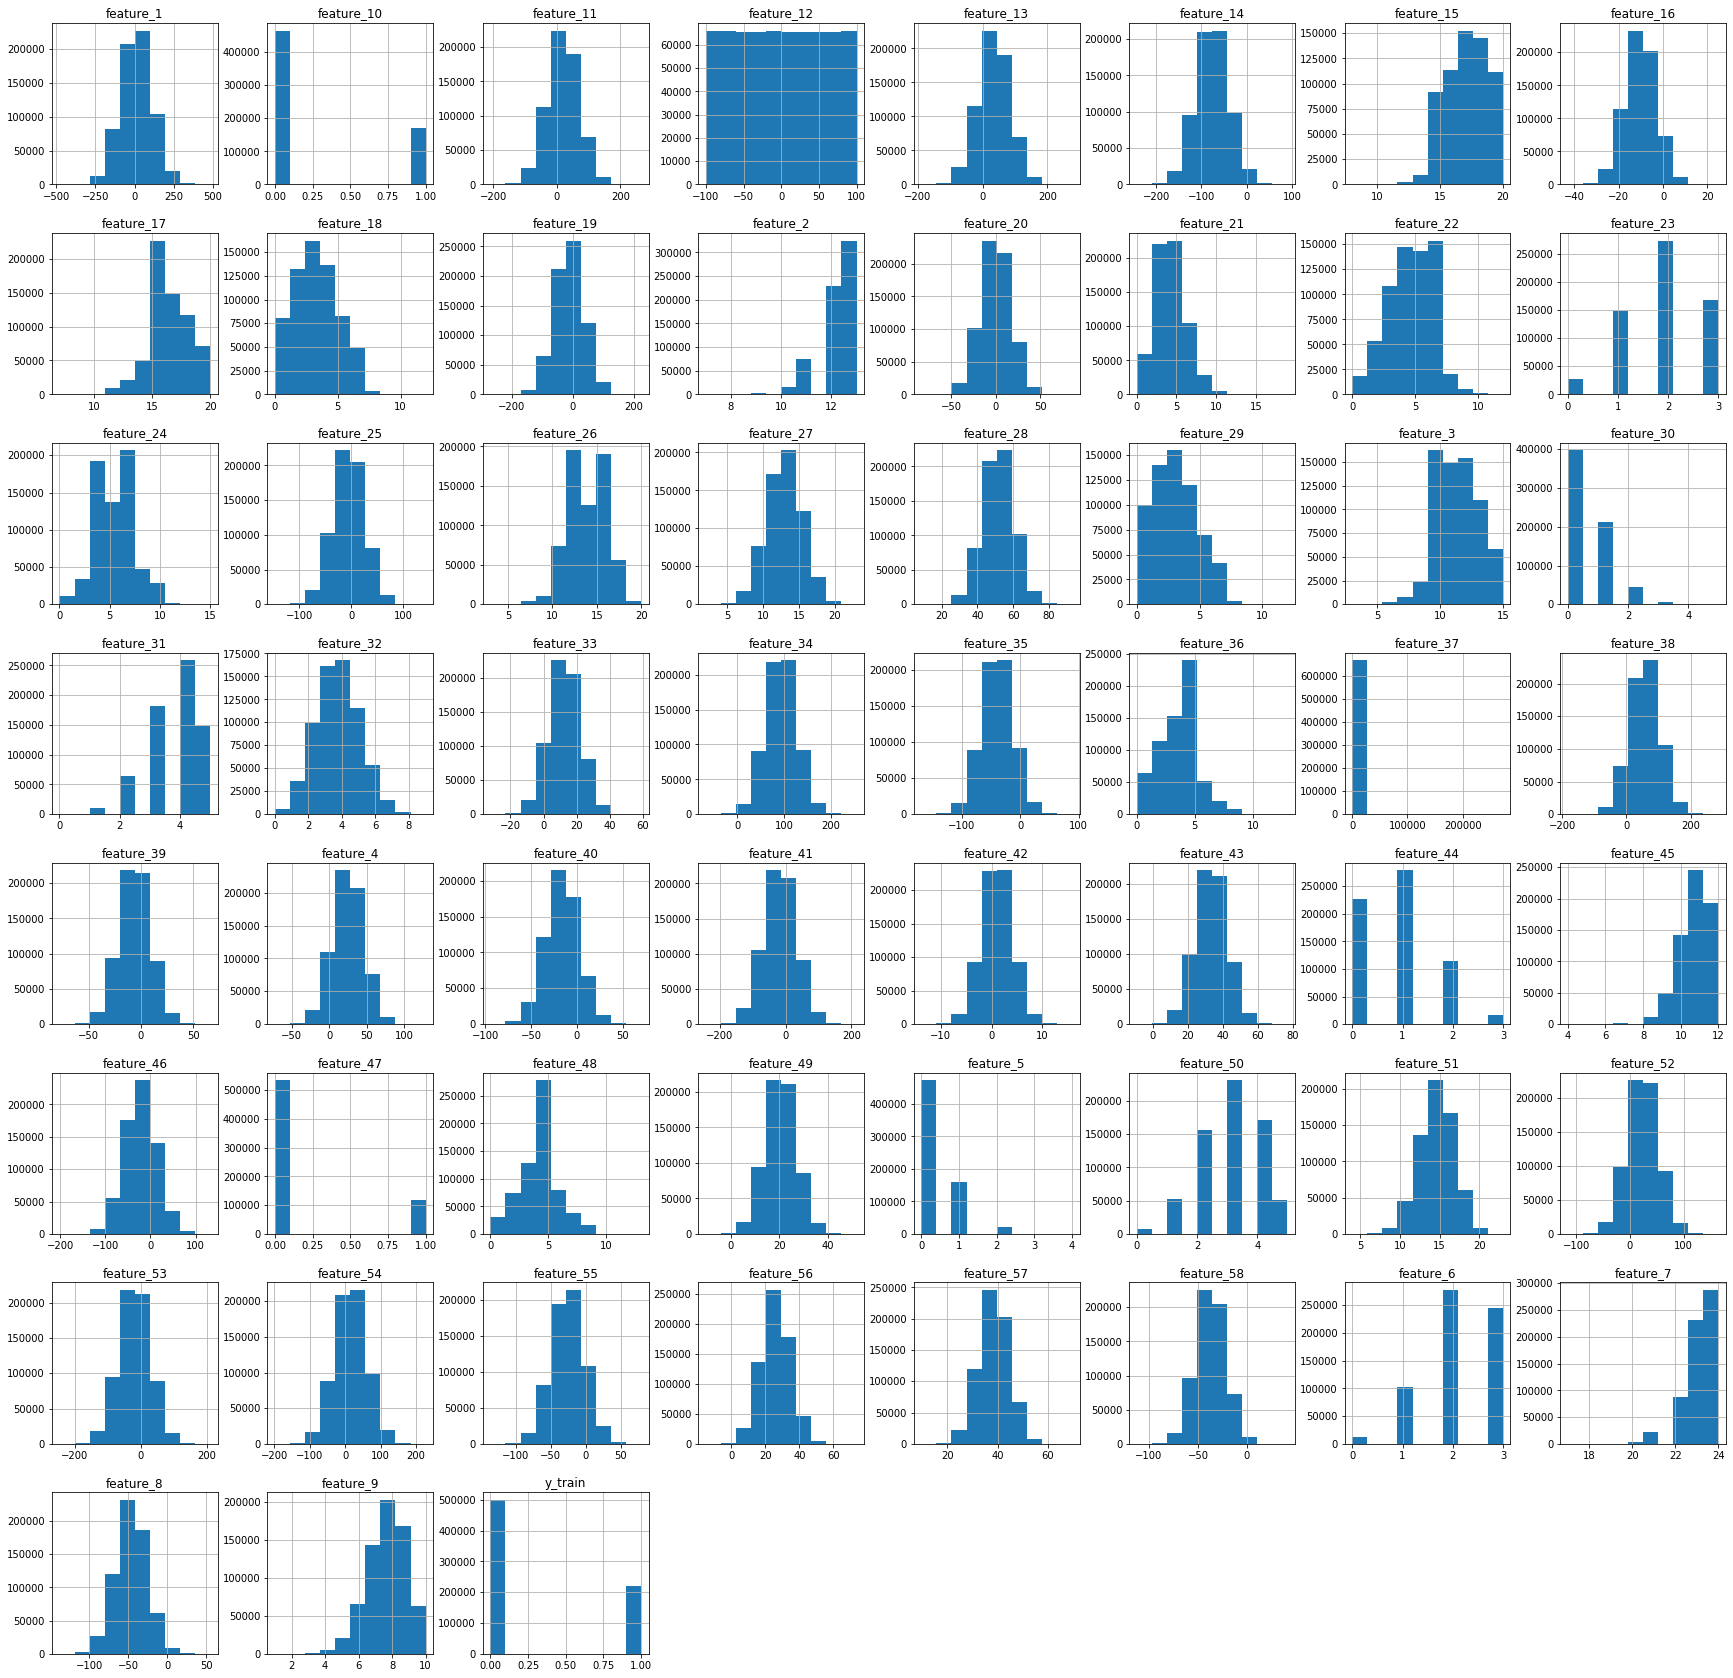

In [27]:
#смотрим распределения полей, что бы составить представление о характере имеющихся данных
#для принятия решения о способе заполнения пропущенных значений
matplotlib.rcParams['figure.figsize'] = (30, 30)
matplotlib.rcParams['font.size'] = (10)
data.hist()
plt.show()

In [28]:
print(data.dropna().shape)

(1985, 59)


In [29]:
#заполняем пропущенные значения некоей константной величиной с сохранением информации о местах пропусков
#(поле fieldname_isnull) это помогает при нахождении нелинейных зависимостей методом случайного леса 
for c in [c for c in data.columns if c != 'y_train']:
    data[f'{c}_isnull'] = data[c].isnull().astype(int)
    data[c] = data[c].fillna(-1000)
    #data[c] = data[c].fillna(data_stats.loc[c, '50%'])

In [30]:
X = data.copy()
y = X['y_train']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.02, random_state=42, stratify=X['y_train'])
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5, random_state=42, stratify=X_test['y_train'])
X_train.drop('y_train', axis=1, inplace=True)
X_test.drop('y_train', axis=1, inplace=True)
X_val.drop('y_train', axis=1, inplace=True)
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(705600, 116) (7200, 116) (7200, 116) (705600,) (7200,) (7200,)


C:\Users\boks\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [31]:
#обучаем простейшую модель catboost_classifier и смотрим что получится
cat_params = {'iterations':300, 'eval_metric':'AUC', 'loss_function':'Logloss', 'thread_count':-1, 'random_seed':42, 'verbose':False}
_train = catboost.Pool(X_train, y_train)
_val = catboost.Pool(X_val, y_val)
model = CatBoost(params = cat_params)
model.fit(_train, eval_set=_val, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [32]:
#возьмём это значения за бейзлайн для дальнейшей работы
roc_auc_score(y_test, model.predict(X_test))

0.7243400128611576

In [ ]:
smote = SMOTE(random_state=42)
X_train_smt,y_train_smt=smote.fit_sample(X_train, y_train)

In [33]:
X_train_smt = pd.DataFrame(data=X_train_smt,columns=X_train.columns)
y_train_smt= pd.DataFrame(data=y_train_smt,columns=['y_train'])
print(X_train.shape, X_train_smt.shape, y_train.shape, y_train_smt.shape)

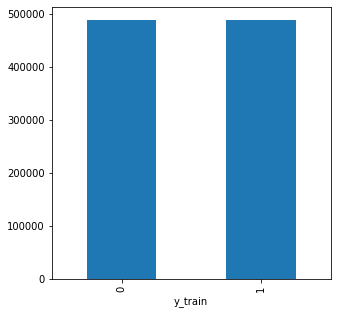

In [36]:
matplotlib.rcParams['figure.figsize'] = (5, 5)
matplotlib.rcParams['font.size'] = (10)
y_train_smt.groupby('y_train').size().plot(kind='bar')
plt.show()

In [20]:
cat_params = {'iterations':300, 'eval_metric':'AUC', 'loss_function':'Logloss', 'thread_count':-1, 'random_seed':42, 'verbose':False}
_train = catboost.Pool(X_train_smt, y_train_smt)
_val = catboost.Pool(X_val, y_val)
model = CatBoost(params = cat_params)
model.fit(_train, eval_set=_val, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [21]:
roc_auc_score(y_test, model.predict(X_test))

0.7202159324484393

In [ ]:
cat_columns = [c for c in data.columns if (data[c].dropna().nunique() <= 20) and ('isnull' not in c) and (c != 'y_train')]
print(cat_columns)

In [ ]:
tsne = TSNE()
data1 = tsne.fit_transform(data[[c for c in data.columns if ('not_null' not in c) and (c != 'y_train')]].T)

In [ ]:
matplotlib.rcParams['figure.figsize'] = (10, 10)
matplotlib.rcParams['font.size'] = (10)
plt.scatter(data1[:,0], data1[:,1])
plt.show()

In [ ]:
cols2learn = []
for c in data.columns:
    test = ttest_ind(data[data['y_train']==0][c].values, data[data['y_train']==1][c].values)
    if (test[1] <= 0.05):
        cols2learn.append(c)
        print(c, test[1])
print(cols2learn)

In [ ]:
pd.concat([data[data['y_train']==1], data[data['y_train']==0].sample(data[data['y_train']==1].shape[0])]).shape

In [ ]:
matplotlib.rcParams['figure.figsize'] = (30, 8)
matplotlib.rcParams['font.size'] = (14)
pd.DataFrame(dict(zip(model.feature_names_,model.feature_importances_)),
             index=[0]).T.sort_values(by=0).iloc[-20:,:].plot(kind='barh')
plt.show()

In [ ]:
top20cols = list(pd.DataFrame(dict(zip(model.feature_names_,model.feature_importances_)),
             index=[0]).T.sort_values(by=0).iloc[-20:,:].index)